# 构建随机森林方法分析空气质量

空气质量（air quality）的好坏反映了空气污染程度，它是依据空气中污染物浓度的高低来判断的。空气污染是一个复杂的现象，在特定时间和地点空气污染物浓度受到许多因素影响。来自固定和流动污染源的人为污染物排放大小是影响空气质量的最主要因素之一，其中包括车辆、船舶、飞机的尾气、工业企业生产排放、居民生活和取暖、垃圾焚烧等。城市的发展密度、地形地貌和气象等也是影响空气质量的重要因素。

<img src = './图片1.png'>  
    ·研究目标：搜集相关数据，运用机器学习对空气质量等级分类；  
    ·选取指标：PM2.5；PM10；SO2；CO；NO2； O3_8h；AQI；质量等级；  
    ·数据及其来源： 
<img src = './图片2.png'>
    ·研究方法及思路：运用随机森林，分别对指标AQI和质量等级进行预测，调用Python的sklearn包。
<img src = './图片3.png'>

## Step 1:准备工作

导入所需的包，运行环境：Python3.7,Anaconda4.2.0

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Step2：数据基本统计分析
首先，看一下数据分布情况。

In [2]:
data=pd.read_csv('./air_train&test.csv',index_col=0,encoding='gb2312')
print (data.head())
print (data.shape)
index=data.index
col=data.columns
class_names=np.unique(data.ix[:,-1])
#print (type(data))
print (class_names)
#print (data.describe())

#划分训练集和验证集
data_train, data_test= train_test_split(data,test_size=0.1, random_state=0)
print ("训练集统计描述：\n",data_train.describe().round(2))
print ("验证集统计描述：\n",data_test.describe().round(2))
print ("训练集信息：\n",data_train.ix[:,-1].value_counts())
print ("验证集信息：\n",data_test.ix[:,-1].value_counts())

           PM2.5  PM10  SO2   CO  NO2  O3_8h  AQI 质量等级
日期                                                    
2013/12/2    109   138   61  2.6   88     11  142   轻度
2013/12/3     64    86   38  1.6   54     45   86    良
2013/12/4     82   101   42  2.0   62     23  109   轻度
2013/12/5     39    56   30  1.2   38     52   56    良
2013/12/6    128   162   48  2.5   78     15  169   中度
(1787, 8)
['严重' '中度' '优' '良' '轻度' '重度']
训练集统计描述：
         PM2.5     PM10      SO2       CO      NO2    O3_8h      AQI
count  1608.0  1608.00  1608.00  1608.00  1608.00  1608.00  1608.00
mean     69.1    95.26    11.90     1.12    47.74    99.90   110.62
std      63.2    71.28    15.21     0.91    23.32    63.51    69.94
min       4.0     0.00     2.00     0.20     7.00     2.00    21.00
25%      26.0    45.00     3.00     0.60    32.00    53.00    60.00
50%      51.0    79.00     6.00     0.90    42.00    86.00    92.00
75%      89.0   124.00    14.00     1.30    58.00   142.00   145.00
max     477.0   550.0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


<img src = './图片4.png'>
<img src = './图片5.png'>

## Step3：构建随机森林回归模型预测AQI
获取训练集和验证集。 

In [3]:
import sys
X_train=data_train.iloc[:,0:-2]
X_test=data_test.iloc[:,0:-2]
feature=data_train.iloc[:,0:-2].columns
print (feature)
y_train=data_train.iloc[:,-2]
y_test=data_test.iloc[:,-2]

Index(['PM2.5', 'PM10', 'SO2', 'CO', 'NO2', 'O3_8h'], dtype='object')


查看各变量间的相关系数。

In [4]:
data.drop([u'质量等级'],axis = 1).corr()

,PM2.5,PM10,SO2,CO,NO2,O3_8h,AQI
PM2.5,1.000000,0.853334,0.538169,0.841337,0.787447,-0.111656,0.940226
PM10,0.853334,1.000000,0.526669,0.717788,0.745122,-0.052869,0.848696
SO2,0.538169,0.526669,1.000000,0.622728,0.621791,-0.327056,0.474458
CO,0.841337,0.717788,0.622728,1.000000,0.807794,-0.337648,0.763714
NO2,0.787447,0.745122,0.621791,0.807794,1.000000,-0.357932,0.713377
O3_8h,-0.111656,-0.052869,-0.327056,-0.337648,-0.357932,1.000000,0.124166
AQI,0.940226,0.848696,0.474458,0.763714,0.713377,0.124166,1.000000


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


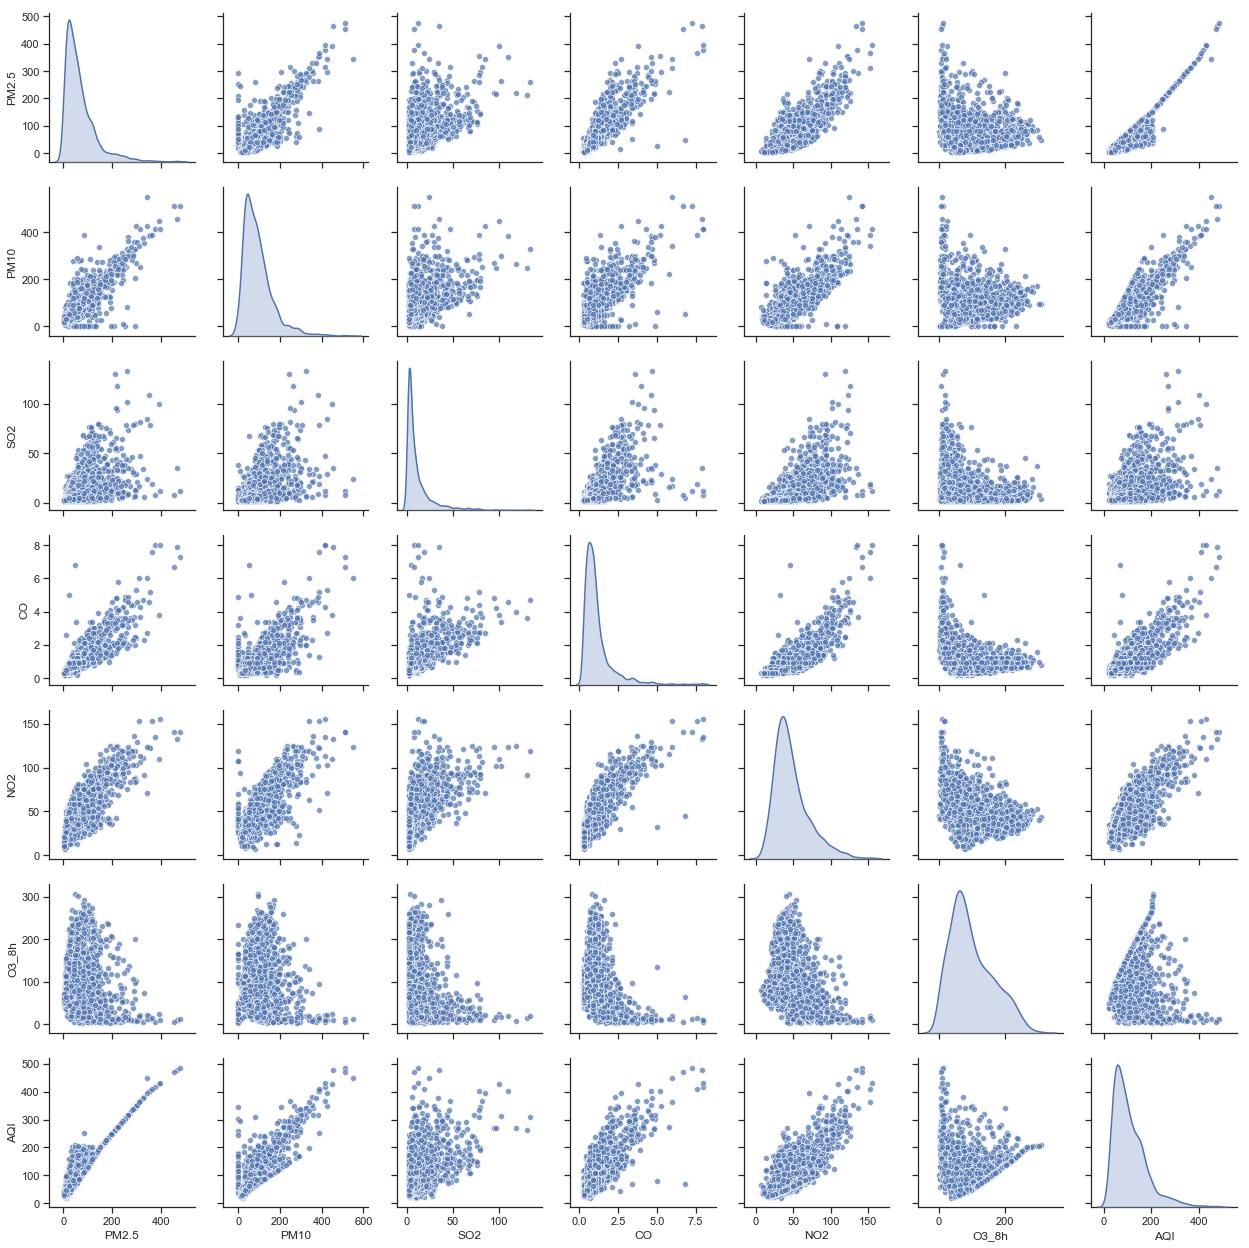

In [5]:
import seaborn as sns
sns.set(style="ticks", color_codes=True);
# 创建自定义颜色调色板
palette = sns.xkcd_palette(['dark blue', 'dark green', 'gold', 'orange'])
# 画散点图矩阵
sns.pairplot(data.drop([u'质量等级'],axis = 1), diag_kind = 'kde', plot_kws=dict(alpha = 0.7))
plt.show()

根据相关系数表和散点图矩阵，PM2.5和PM10与AQI的线性相关性最大，相关系数超过了0.8，其次是CO和NO2，相关系数超过了0.7。但是，PM2.5与PM10、CO的相关系数超过了0.8，CO与NO2的相关系数也超过了0.8，即各因素间存在多重共线性，不满足相互独立的条件，不能直接进行线性回归，因此选用随机森林预测AQI。

## Step 4:模型调参

In [ ]:
'''模型调参'''
##参数选择
from sklearn.model_selection import RandomizedSearchCV
criterion=['mse','mae']
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'criterion':criterion,
                'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#构建模型
clf= RandomForestRegressor()
clf_random = RandomizedSearchCV(estimator=clf, param_distributions=random_grid,
                              n_iter = 10,  
                              cv = 3, verbose=2, random_state=42, n_jobs=1)
#回归
clf_random.fit(X_train, y_train)
print (clf_random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=80, criterion=mae, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=80, criterion=mae, bootstrap=False, total=   6.6s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=80, criterion=mae, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=80, criterion=mae, bootstrap=False, total=   6.5s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=80, criterion=mae, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=80, criterion=mae, bootstrap=False, total=   7.0s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=100, criterion=mae, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=100, criterion=mae, bootstrap=False, total=  28.9s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=100, criterion=mae, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=100, criterion=mae, bootstrap=False, total=  29.2s
[CV] n_estimators=800, min_sample

## Step 5:模型训练、验证及评估

In [ ]:
from pyecharts import Bar
%matplotlib inline
rf=RandomForestRegressor(criterion='mse',bootstrap=False,max_features='sqrt', max_depth=20,min_samples_split=10, n_estimators=1200,min_samples_leaf=2)

rf.fit(X_train, y_train) 
y_train_pred=rf.predict(X_train)
y_test_pred=rf.predict(X_test)

#指标重要性
print (rf.feature_importances_)
bar=Bar()
bar.add('指标重要性',feature, rf.feature_importances_.round(2),is_label_show=True,label_text_color='#000')
bar.render('指标重要性.html')

from sklearn.metrics import mean_squared_error,explained_variance_score,mean_absolute_error,r2_score
print ("决策树模型评估--训练集：")
print ('训练r^2:',rf.score(X_train,y_train))
print ('均方差',mean_squared_error(y_train,y_train_pred))
print ('绝对差',mean_absolute_error(y_train,y_train_pred))
print ('解释度',explained_variance_score(y_train,y_train_pred))

print ("决策树模型评估--验证集：")
print ('验证r^2:',rf.score(X_test,y_test))
print ('均方差',mean_squared_error(y_test,y_test_pred))
print ('绝对差',mean_absolute_error(y_test,y_test_pred))
print ('解释度',explained_variance_score(y_test,y_test_pred))

<img src = './图片8.png'>
<img src = './图片9.png'>
通过随机森林回归得到，PM2.5和PM10仍旧是对AQI影响最大的前两个指标，其次是NO2、O3_8h、CO，基本与相关系数分析结果一致。
<img src = './图片10.png'>
通过模型评估表得，所构建的随机森林预测AQI模型，训练集和验证集上拟合优度R^2分别为0.9965、0.9858，模型效果不错，可以用该模型对AQI进行预测。

## Step6:预测
用构建的模型预测2016年中国环保重点城市AQI。

In [ ]:
'''预测'''
data_pred=pd.read_csv('./air.csv',index_col=0,encoding='gb2312')
index=data_pred.index
y_pred=rf.predict(data_pred.values)

#将预测结果保存到文件中
result_reg=pd.DataFrame(index)
result_reg['AQI']=y_pred
result_reg.to_csv('./result_reg_city.txt',encoding='gb2312')
print (result_reg)

## Step 7：可视化预测结果

In [ ]:
#可视化预测结果
from pyecharts import Geo
import pandas as pd
df=pd.read_csv('./result_reg_city.txt',index_col=0,encoding='gb2312')
print (df.head())
geo = Geo(
    "全国主要城市空气质量",
    "",
    title_color="#fff",
    title_pos="center",
    width=1200,
    height=600,
    background_color="#404a59",
)
geo.add(
    "",
    df.iloc[:,0],
    df.iloc[:,1],
    visual_range=[0, 300],
    visual_text_color="#111",
    symbol_size=15,
    is_visualmap=True, 
    is_piecewise=True,
    #visual_split_number=6
    pieces=[{"max": 50, "min": 0, "label": "优:0-50"},
            {"max": 100, "min": 50, "label": "良:51-100"},
            {"max": 150, "min": 100, "label": "轻度污染:101-150"},
            {"max": 200, "min": 150, "label": "中度污染:151-200"},
            {"max": 300, "min": 200, "label": "重度污染:201-300"},
            {"max": 1000, "min": 300, "label": "严重污染:>300"},        
        ]
)
geo.render('全国重点城市AQI预测结果的可视化.html')

 <img src = './图片0.png'>